In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
!pip install sentencepiece

In [2]:
from transformers import TFXLMRobertaModel,XLMRobertaTokenizer

In [3]:
sent_length=210

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,BatchNormalization,ReLU,Dropout,Input

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
import pickle
with open('../input/jigsaw-kaggle-xlmroberta/train_data_xlm_roberta.pkl','rb') as f:
    model_inputs=pickle.load(f)
with open('../input/jigsaw-kaggle-xlmroberta/train_data_labels_xlm_roberta.pkl','rb') as f:
    model_outputs=pickle.load(f)
with open('../input/jigsaw-kaggle-xlmroberta/valid_data_xlm_roberta.pkl','rb') as f:
    valid_inputs=pickle.load(f)
with open('../input/jigsaw-kaggle-xlmroberta/valid_data_labels_xlm_roberta.pkl','rb') as f:
    valid_outputs=pickle.load(f)

In [7]:
batch_size=32*strategy.num_replicas_in_sync
valid_batch_size=16*strategy.num_replicas_in_sync

In [8]:
dataset=tf.data.Dataset.from_tensor_slices((model_inputs,model_outputs))
dataset=dataset.shuffle(512)
dataset=dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
next(iter(dataset))

({'input_ids': <tf.Tensor: shape=(256, 210), dtype=int32, numpy=
  array([[    0,    44, 69112, ...,     1,     1,     1],
         [    0, 94724, 73171, ...,     1,     1,     1],
         [    0,    44, 32635, ...,     1,     1,     1],
         ...,
         [    0,  1301,    10, ...,     1,     1,     1],
         [    0,   360, 32692, ..., 10002,   247,     2],
         [    0,    44,   438, ...,     1,     1,     1]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(256, 210), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>},
 <tf.Tensor: shape=(256,), dtype=int64, numpy=
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [10]:
valid_dataset=tf.data.Dataset.from_tensor_slices((valid_inputs,valid_outputs))
valid_dataset=valid_dataset.shuffle(512)
valid_dataset=valid_dataset.batch(valid_batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
next(iter(valid_dataset))

({'input_ids': <tf.Tensor: shape=(128, 210), dtype=int32, numpy=
  array([[     0,   1208,  16195, ...,      1,      1,      1],
         [     0,    310,  10545, ...,      1,      1,      1],
         [     0,   3936,  74328, ...,      1,      1,      1],
         ...,
         [     0, 100061,  21376, ...,      1,      1,      1],
         [     0,    503,   3719, ...,  98780,    143,      2],
         [     0, 167025,    262, ...,      1,      1,      1]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(128, 210), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>},
 <tf.Tensor: shape=(128,), dtype=int64, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0

In [12]:
with strategy.scope():
    xlmroberta_model=TFXLMRobertaModel.from_pretrained('jplu/tf-xlm-roberta-base')
    ins1=Input((sent_length,),dtype=tf.int32,name='input_ids')
    ins2=Input((sent_length,),dtype=tf.int32,name='attention_mask')
    pre_model=xlmroberta_model({'input_ids':ins1,'attention_mask':ins2})
    x=Dropout(0.1)(pre_model[1])
    outs=Dense(1,activation='sigmoid')(x)
    model=Model(inputs={'input_ids':ins1,'attention_mask':ins2},outputs=outs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy')

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


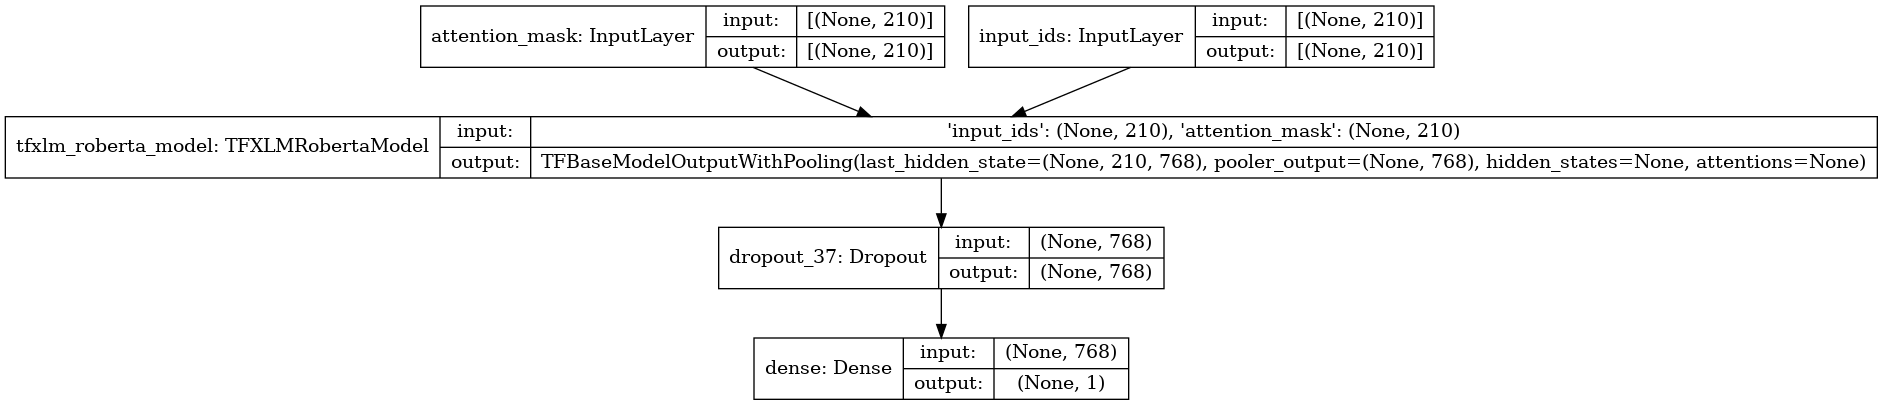

In [13]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [14]:
saver=tf.keras.callbacks.ModelCheckpoint(filepath='xlm_roberta_jigsaw_weights.h5',
                                        save_best_only=True,save_freq='epoch',monitor='val_loss',
                                        mode='min',verbose=True,save_weights_only=True)

In [15]:
model.fit(dataset,validation_data=valid_dataset,epochs=4,callbacks=[saver])

Epoch 1/4


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


8203/8203 [==============================] - 2136s 251ms/step - loss: 0.3346 - val_loss: 0.3353

Epoch 00001: val_loss improved from inf to 0.33528, saving model to xlm_roberta_jigsaw_weights.h5
Epoch 2/4
8203/8203 [==============================] - 2006s 245ms/step - loss: 0.2955 - val_loss: 0.3615

Epoch 00002: val_loss did not improve from 0.33528
Epoch 3/4
8203/8203 [==============================] - 2007s 245ms/step - loss: 0.2859 - val_loss: 0.3699

Epoch 00003: val_loss did not improve from 0.33528
Epoch 4/4
8203/8203 [==============================] - 2008s 245ms/step - loss: 0.2772 - val_loss: 0.3661

Epoch 00004: val_loss did not improve from 0.33528


In [16]:
test_data=pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [17]:
test_data.head()

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [18]:
x_tokenizer=XLMRobertaTokenizer.from_pretrained('jplu/tf-xlm-roberta-base')

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

In [23]:
test_inputs={'input_ids':np.empty((test_data.shape[0],sent_length),np.int32),
              'attention_mask':np.empty((test_data.shape[0],sent_length),np.int32)}

In [24]:
from tqdm import tqdm

In [25]:
for i in tqdm(range(test_data.shape[0])):
    tokenized=x_tokenizer.tokenize(str(test_data.loc[i,'content']))
    if len(tokenized)>sent_length-2:
        tokenized=['<s>']+tokenized[:(sent_length-2)]+['</s>']
    else:
        curr_len=len(tokenized)
        tokenized=['<s>']+tokenized+['</s>']+['<pad>']*(sent_length-curr_len-2)
    token_ids=x_tokenizer.convert_tokens_to_ids(tokenized)
    mask=np.char.not_equal('<pad>',tokenized).astype(np.int32)
    test_inputs['input_ids'][i,]=token_ids
    test_inputs['attention_mask'][i,]=mask

100%|██████████| 63812/63812 [00:51<00:00, 1245.19it/s]


In [26]:
with strategy.scope():
    xlmroberta_model=TFXLMRobertaModel.from_pretrained('jplu/tf-xlm-roberta-base')
    ins1=Input((sent_length,),dtype=tf.int32,name='input_ids')
    ins2=Input((sent_length,),dtype=tf.int32,name='attention_mask')
    pre_model=xlmroberta_model({'input_ids':ins1,'attention_mask':ins2})
    x=Dropout(0.1)(pre_model[1])
    outs=Dense(1,activation='sigmoid')(x)
    model=Model(inputs={'input_ids':ins1,'attention_mask':ins2},outputs=outs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='binary_crossentropy')
    model.load_weights('./xlm_roberta_jigsaw_weights.h5')

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [27]:
predictions=model.predict(test_inputs)

In [28]:
sub=pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [29]:
sub['toxic']=predictions

In [30]:
sub.head()

,id,toxic
0,0,0.114918
1,1,0.037484
2,2,0.300576
3,3,0.040152
4,4,0.042617


In [31]:
sub.to_csv('submission.csv',index=False)